In [78]:
import pandas as pd
import os 
from pathlib import Path

condition = "Dreamachine"



metaproject_name = 'TopicModelling_META'
subproject_name = 'TopMod_pipeline'
dataset_name = f'{condition}_dataset.csv'

PROJDIR = os.path.expanduser(f"~/projects/{metaproject_name}")
DATADIR = os.path.join(PROJDIR,f'DATA/{dataset_name}')
CODEDIR = os.path.join(PROJDIR,f'{subproject_name}')

In [79]:
reports = pd.read_csv(DATADIR,usecols=['text'])
# reports = pd.read_csv(DATADIR)

# Save the DataFrame to a new csv file
# reports.to_csv(DATADIR, index=False)

print(reports.info())
reports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    377 non-null    object
dtypes: object(1)
memory usage: 3.1+ KB
None


,text
0,the colours made patterns when i had my eyes c...
1,Intense chaos. And then my mind checked out an...
2,good stuff.\n
3,a pattern of red and white lights thatflashed ...
4,i wentback to many hard and mostly beautiful m...


### Stop word extraction 

/!\ The extended list of stop words have been selected arbitrary by hand, after having had a look at the data

In [80]:
dreamachine_stop_words = ['yes','kind','looking','say','sort','sure','look','makes','pasue','distance','always','think','know','literally','describe','descriptives','differently','let','depending','CR','okay','mm','Okay','yeah','thing','stop','erm','pause','experience','experiences','felt','closed','eyes','experienced','like','many','also','end','one','eg','another','thanks','fell','feels','alot','charlie','keep','made','almost','feel','really','something','would','never','back','lot','things','much','could','see','saw','sometimes','thoughts','bit','nd','sense','devtest','light','lights','thought','well','way','away','get','coming','came','take','though']
general_stop_words = ['from']
stop_words_list = dreamachine_stop_words+general_stop_words
# print(stop_words_list)

In [81]:
import re # Load the regular expression library


# Remove punctuation
def process_text(x):
    if isinstance(x, str):  # check if x is of type string
        x = re.sub('[,\.!?;]', '', x)  # if it is, do the replacement
        x = re.sub('^[0-9]+', '', x)  # remove initial numbers
        return x.lower()
    else:
        return ""  # otherwise, return an empty string or you can convert it to string by using `return str(x)`

reports['text_processed'] = reports['text'].map(process_text)

# Convert the titles to lowercase
reports['text_processed'] = reports['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
reports['text_processed'].head()



<>:7: DeprecationWarning: invalid escape sequence '\.'
<>:7: DeprecationWarning: invalid escape sequence '\.'
/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_13604/639740560.py:7: DeprecationWarning: invalid escape sequence '\.'
  x = re.sub('[,\.!?;]', '', x)  # if it is, do the replacement


0    the colours made patterns when i had my eyes c...
1    intense chaos and then my mind checked out and...
2                                         good stuff\n
3    a pattern of red and white lights thatflashed ...
4    i wentback to many hard and mostly beautiful m...
Name: text_processed, dtype: object

### Primary exploratory analysis : general word cloud (on the complete dataset, without stop words)

/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


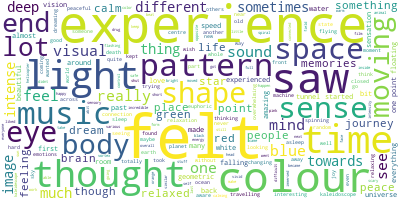

In [82]:
# Import the wordcloud library
# !pip install wordcloud
import wordcloud
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(reports['text_processed'].values))


# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# LDA model

### Preparing input data for LDA model training 
1. Tokenization text & stop words removal 

In [83]:
import gensim #NLP library for representing documents as semantic vectors

from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words('english')
stop_words.extend(stop_words_list)

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
indiv_reports = reports.text_processed.values.tolist() #list containing the report of each participants 
reports_words = list(sent_to_words(indiv_reports))

# remove stop words
reports_words = remove_stopwords(reports_words) #list of list of words from the report of each individual participant

[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2. Conversion tokenized object



The variable "texts" is a list of open reports : each element corresponds to an individual (preprocessed) verbal report 
We create a corpus from "texts", by converting each element into a bag-of-words (BoW) representation.
BoW is a list of (word_id, word_count) tuples where "word_id" is the unique ID of the word in the dictionary and "word_count" is the number of times the word appears in the document


In [84]:
import gensim.corpora as corpora

# Creation Dictionary
id2word = corpora.Dictionary(reports_words)

# Creation Corpus
texts = reports_words #assigns the "data_words" variable to a new variable called "texts"

# Creation Term Document Frequency matrix
corpus = [id2word.doc2bow(text) for text in texts] #converts each element (preprocessed open report) of "texts" into a bag-of-words representation

n_reports = len(corpus) #number of reports from the Dreamachine
print(f'Number of reports in the "{condition}" Dataset : ',n_reports)


Number of reports in the "Dreamachine" Dataset :  377


Corpus is list of tuples of size n_reports

Each row $<i, j>$ contains a count, i.e. how many times the word $j$ appears in document (indiv report) $i$

Example : below we see that 'colours' appears twice in the first report

In [85]:
#Sanity check : print the report of the first participant and its associated list of words
print(reports['text_processed'][0])
print(reports_words[0]) #only important words have been selected
print(corpus[0]) 

the colours made patterns when i had my eyes closed - almost like a weave of colours in a woollen fabric

['colours', 'patterns', 'weave', 'colours', 'woollen', 'fabric']
[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1)]


# Optimisation : testing different values for the number of topics to find the optimal number of topics

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


# Vectorize words
vectorizer = CountVectorizer(stop_words=stop_words, 
                             max_df=0.95, #any word that appears in more than 95% of the documents will be ignored
                             min_df=3) #any word that appears in less than 2 documents will be ignored 
X = vectorizer.fit_transform(reports['text_processed'])

# Define search parameters
search_params = {'n_components': [2,3,4,5], 'learning_decay': [.5, .7, .9]} #(supposed to correspond to pheno dimensions)

# Initialize the LDA model
lda = LatentDirichletAllocation()

# Grid search to find the best model
model = GridSearchCV(lda, param_grid=search_params, cv=5)

# Fit the grid search to the data
model.fit(X)

# Print the best model and its parameters
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)

# Assign the best model to a variable
best_lda_model = model.best_estimator_

# Transform the data
X_topics = best_lda_model.transform(X)

# Print the topics
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(words[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

# Print the top 10 words for each topic
print_topics(best_lda_model, vectorizer)

# Plot the grid search results
results = pd.DataFrame(model.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(search_params['n_components']), len(search_params['learning_decay']))

plt.figure(figsize=(12, 8))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xticks(np.arange(len(search_params['learning_decay'])), search_params['learning_decay'], rotation=45)
plt.yticks(np.arange(len(search_params['n_components'])), search_params['n_components'])
plt.xlabel('Learning decay')
plt.ylabel('Num Topics')
plt.colorbar()
plt.title('Grid Search Scores')
plt.show()


/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cr'] not in stop_words.
  warnings.warn(


We recall that the number of topics (here in LDA model) refers to the number of latent (hidden) topics that the model has identified in the corpus of text. Each topic can be represented by a set of words that are most strongly associated with that topic. Therefore, the present optimisation indicates that a number of 3 latent topics is optimal to represent the latent topics of the verbal reports.

The heatmap allows for visualizing the grid search results and helps in selecting the optimal values for the number of topics and learning decay rate. The brighter color regions represent the better scores, and the position of the brightest point indicates the optimal values. 


### Visualisation 10 most salient words for the optimized number of topics

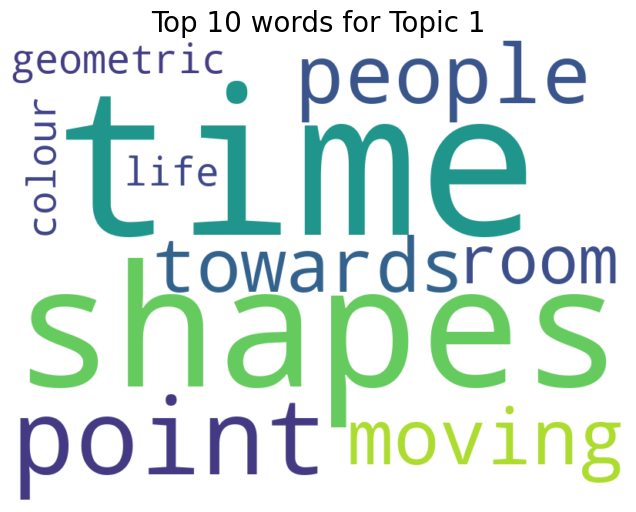

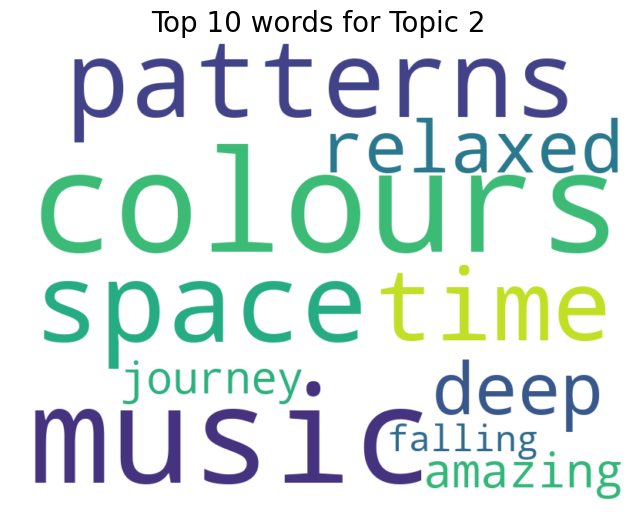

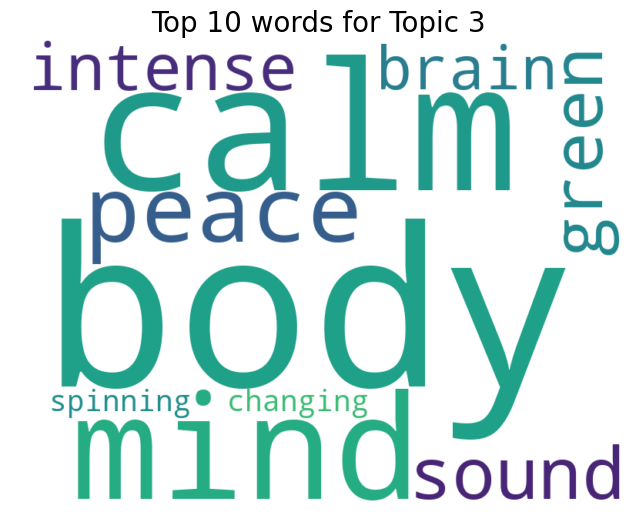

In [ ]:

# Set the number of topics to display, corresponding to the optimal number of topics found above
optim_num_topics = len(model.best_estimator_.components_)

# Get the top 10 words for each topic
top_words = []
for idx, topic in enumerate(model.best_estimator_.components_):
    topic_words = [(vectorizer.get_feature_names_out()[i], topic[i])
                   for i in topic.argsort()[:-11:-1]]
    top_words.append(topic_words)

# Create the word cloud for each topic
for i in range(optim_num_topics):
    plt.figure(figsize=(8, 6))
    wc = WordCloud(background_color="white", max_words=50, width=800, height=600)
    wc.generate_from_frequencies(dict(top_words[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top 10 words for Topic {i+1}", fontdict={'fontsize': 20})
    plt.show()



# Set the number of topics to display, corresponding to the optimal number of topics found above
optim_num_topics = len(model.best_estimator_.components_)

# Get the top 10 words for each topic
top_words = []
for idx, topic in enumerate(model.best_estimator_.components_):
    topic_words = [(vectorizer.get_feature_names_out()[i], topic[i])
                   for i in topic.argsort()[:-11:-1]]
    top_words.append(topic_words)

# Create the word cloud for each topic
for i in range(optim_num_topics):
    plt.figure(figsize=(8, 6))
    wc = WordCloud(background_color="white", max_words=50, width=800, height=600)
    wc.generate_from_frequencies(dict(top_words[i]))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top 10 words for Topic {i+1}", fontdict={'fontsize': 20})
    plt.show()


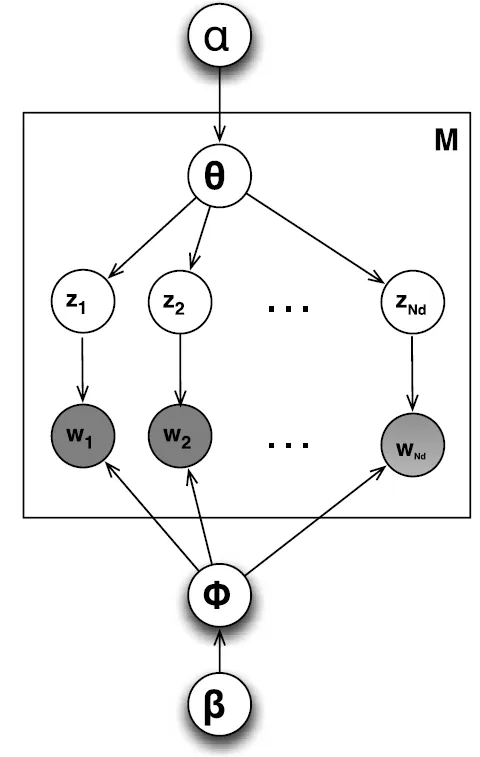

Grey circles : oberseved variables (ie words in the corpus)

White circles : latent variables

M : number of documents in the corpus 

N : number of words in each document 

$α$ : parameter of the Dirichlet prior on the per-document topic distributions

$θ$ : topic distribution for a document 

==> take a mixture describing the distribution of topics for each report

### LDA Model 



In [ ]:
from pprint import pprint

# Choose the number of topics ntopic that the algorithm will try to discover (here we use the number found above in the optimization part, but can change if necessary to see how it changes the topics)
ntopics = optim_num_topics #each topic is a combination of keywords and each keyword contributes a certain weightage to the topic


# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word, #dictionary that maps unique integer IDs to each word in the vocabulary of the corpus
                                       num_topics=ntopics)
# Print the keywords for each of the n topics and weightage of each keywords
pprint(lda_model.print_topics()) 
doc_lda = lda_model[corpus]

[(0,
  '0.009*"colours" + 0.007*"mind" + 0.007*"space" + 0.006*"patterns" + '
  '0.004*"time" + 0.004*"life" + 0.004*"moving" + 0.004*"shapes" + '
  '0.004*"body" + 0.004*"green"'),
 (1,
  '0.008*"music" + 0.007*"shapes" + 0.007*"time" + 0.007*"body" + 0.006*"deep" '
  '+ 0.006*"moving" + 0.006*"towards" + 0.006*"colours" + 0.005*"patterns" + '
  '0.005*"blue"'),
 (2,
  '0.007*"time" + 0.006*"different" + 0.005*"colours" + 0.005*"peace" + '
  '0.005*"space" + 0.005*"images" + 0.004*"feeling" + 0.004*"water" + '
  '0.004*"people" + 0.004*"started"')]


**Output LDA**
The output of the LDA algorithm is a set of topic distributions, one for each document, and a set of word distributions, one for each topic. These distributions can then be used to identify the main dimensions in the collection of reports and to classify new reports based on their topic distributions.

## Model perplexity and coherence score



*   Lower the perplexity better the model. normalized log-likelihood of a held-out test set
*   Higher the topic coherence, the topic is more human interpretable. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic

In [ ]:
from gensim.models import CoherenceModel# spaCy for preprocessing

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reports_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.845421080472007

Coherence Score:  0.3901504367319344


## LDA Analysis : visualisation of the topics

In [ ]:
results_path = os.path.join('../TopicModelling_MATA/LDA_visu_{}_{}_topics'.format(condition,ntopics))
results_path

'../TopicModelling_MATA/LDA_visu_Dreamachine_3_topics'

**Left figure : Intertopic distance map**

Gives a sense of the statistical nearness of topics from each other

Topics represented as circles, where circle size indicates the relative statistical weight of topics


**Right figure : top words associated with specific topic**

Shows top words associated with the specific topic selected in the left panel, along with bar graphs for their weight

Blue bar : for any word represents that word’s frequency in the overall topic model

Red bar : word’s frequency within the specific selected topic


**Note on relevance metric**
NB : relevance metric λ balances the contribution of the two factors that influence the score: the probability of a word given a topic and the probability of the topic given a word. When λ is set to 1, the relevance score is purely based on the probability of a word given a topic, while when it is set to 0, it is solely based on the probability of the topic given a word.

A higher value of λ will emphasize the most probable words for a given topic, while a lower value of λ will produce topics that are more specific to the context of the documents being analyzed.

In [ ]:

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDA_vis_path = os.path.join('../../results/LDA_dreamachine/LDA_visu_{}_topics'.format(ntopics))

if 1 == 1:
    LDA_visu = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDA_vis_path, 'wb') as f:
        pickle.dump(LDA_visu, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDA_vis_path, 'rb') as f:
    LDA_visu = pickle.load(f)

pyLDAvis.save_html(LDA_visu,'../../results/LDA_dreamachine/LDA_visu_{}_topics.html'.format(ntopics))

LDA_visu

/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004807 -0.054074       1        1  38.877871
0     -0.052591  0.023153       2        1  30.643789
2      0.047784  0.030921       3        1  30.478340, topic_info=          Term       Freq      Total Category  logprob  loglift
113  different  10.000000  10.000000  Default  30.0000  30.0000
11        mind  12.000000  12.000000  Default  29.0000  29.0000
399      peace  10.000000  10.000000  Default  28.0000  28.0000
123     shapes  15.000000  15.000000  Default  27.0000  27.0000
94        deep  11.000000  11.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
99       point   2.836188  11.202209   Topic3  -5.9399  -0.1855
128       body   2.737723  16.101770   Topic3  -5.9752  -0.5836
2     patterns   2.641004  16.530900   Topic3  -6.0112  -0.6459
288      found   2.517239   5.924633   Topic3  -6.0592   0.3322
110      sound   2.527822   8.007664   Topic3  -6.0550   0.0351

[225 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1386      3  0.508874      acid
1598      3  0.762620  adorable
389       1  0.796147   amazing
389       2  0.132691   amazing
130       1  0.304850    around
...     ...       ...       ...
80        2  0.257387      wish
80        3  0.772160      wish
840       3  0.760906      womb
709       3  0.762590  wooshing
978       1  0.971673      year

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

### Visualisation salient words per theme

/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


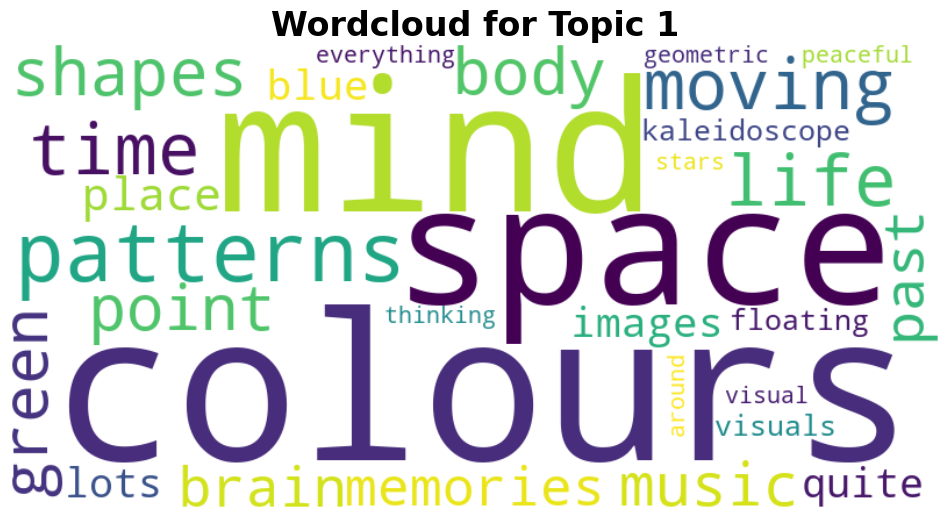

/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


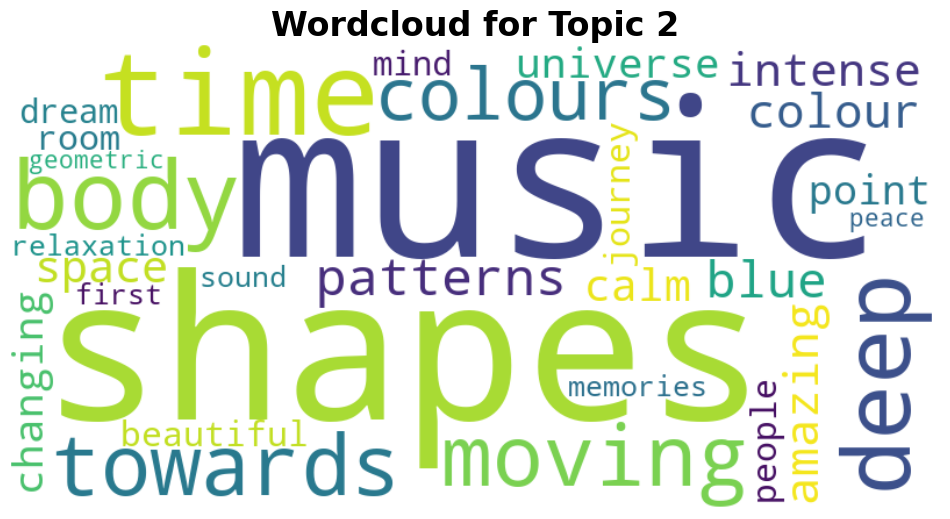

/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


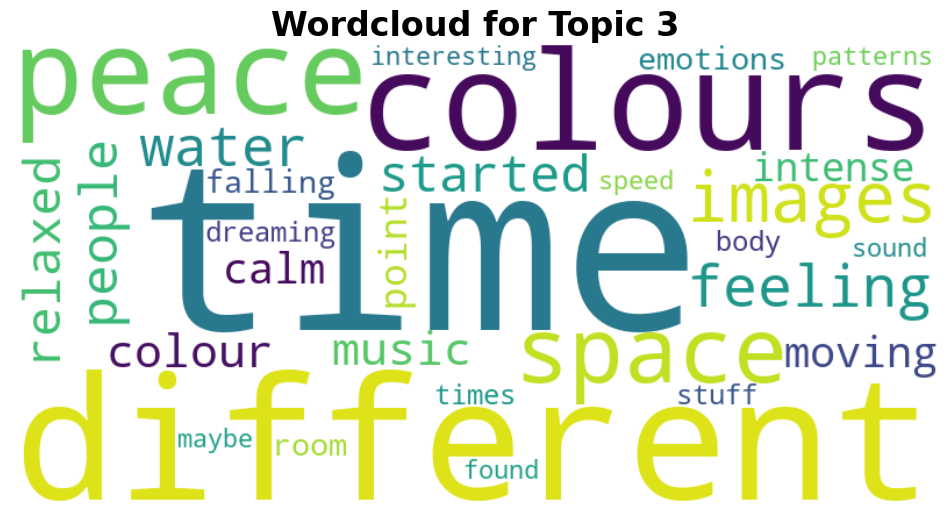

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Loop over the three topics
for i in range(ntopics):
    # Get the top 30 most salient words for each topic
    top_words = lda_model.get_topic_terms(i, topn=30)

    # Create a frequency dictionary for the words
    word_freq = {lda_model.id2word[term_id]: freq for term_id, freq in top_words}

    # Generate the wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Display the wordcloud with a title
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud for Topic {i+1}", fontsize=24, fontweight='bold')
    plt.show()